In [42]:
import os
import numpy as np
import pandas as pd
from ast import literal_eval
from tqdm import tqdm
import random
import tensorflow as tf
import re
import matplotlib
from matplotlib import pyplot as plt
import sys
import copy
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
#from tensorflow.python.ops.numpy_ops import np_config
#np_config.enable_numpy_behavior()
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, InputLayer, Reshape
from sklearn.metrics import roc_curve, auc, average_precision_score, matthews_corrcoef, f1_score, precision_score

In [43]:
#Put in master excel sheet from Sugiyama et al. 
excel1 = 'Train_Data_NGlycositeAtlas.csv'
excel2 = 'Test_Data_NGlycositeAtlas.csv'
#file_name = 'UP000005640_9606.txt' #Reference proteome for humans
file_name = '20240202_NGlycosite_IDs.txt' #Uniprot seqs for Nglycosite atlas

df = pd.read_csv(file_name, sep='delimiter', header=None)

isoform_file = '20240202_NGlycosite_IDs_with_isoforms_short.fasta' #Uniprot seqs for Nglycosite atlas

C:\Users\Clair\AppData\Local\Temp\ipykernel_12512\1261787865.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file_name, sep='delimiter', header=None)


In [44]:
#Load all possible Uniprot IDs from reference proteome
df.fillna("NA", inplace=True) # just in case any "NA" got turned into NaNs
ID_df = df[df[0].str.contains(">")][0]
ID_list = []
for i in range(len(ID_df)):  
    long=ID_df.iloc[i].split("|")[1]
    ID_list.append(long.split(" ")[0])
ID_array = np.array(ID_list)
#print (ID_array)
print("ID array has been made!")

#Makes array of sequences
sequences = []
indices_of_uniprot_ids = list(df[df[0].str.contains(">")].index)
for i in range(len(indices_of_uniprot_ids)-1):
    # concatenate all into one string
    sequences.append(df[indices_of_uniprot_ids[i]+1:indices_of_uniprot_ids[i+1]][0].sum())
    if i == len(indices_of_uniprot_ids)-2:
        sequences.append(df[indices_of_uniprot_ids[i+1]+1:][0].sum())
sequences = np.array(sequences)
print("Lines have been separated!")

# Creates dictionary that maps Uniprot ID to sequence
pairs = zip(ID_array, sequences)
protein_dict = {A:B for A,B in pairs}
print("protein_dict has been made!")

ID array has been made!
Lines have been separated!
protein_dict has been made!


In [45]:
#Let's start with the data from NGlycoSite Atlas
#Load data and convert to numpy array
sheet1 = pd.read_csv(excel1)
Data1=sheet1[["PID", "Position", "label"]]

sheet2 = pd.read_csv(excel2)
Data2=sheet2[["PID", "Position", "label"]]

Train_ID=Data1.iloc[:, 0] 
Train_ID=Train_ID.to_numpy(dtype=str)

Train_Position=Data1.iloc[:, 1] 
Train_Position=Train_Position.to_numpy(dtype=str)

Train_Label=Data1.iloc[:, 2] 
Train_Label=Train_Label.to_numpy(dtype=str)

Test_ID=Data2.iloc[:, 0] 
Test_ID=Test_ID.to_numpy(dtype=str)

Test_Position=Data2.iloc[:, 1] 
Test_Position=Test_Position.to_numpy(dtype=str)

Test_Label=Data2.iloc[:, 2] 
Test_Label=Test_Label.to_numpy(dtype=str)

dataset=np.stack((np.concatenate((Train_ID, Test_ID)), np.concatenate((Train_Position, Test_Position)), np.concatenate((Train_Label, Test_Label))), axis=1)
print (np.shape(dataset))



(26743, 3)


In [46]:
#Now we need to add isoform sequences into dictionary
idf = pd.read_csv(isoform_file, sep='delimiter', header=None)
idf.fillna("NA", inplace=True) # just in case any "NA" got turned into NaNs

ID_idf = idf[idf[0].str.contains(">")][0]
ID_ilist = []
for i in range(len(ID_idf)):  #This dataset uses a different Uniprot form than previous so select it differently
    long=ID_idf.iloc[i].split("|")[1]
    if long in dataset[:, 0]:
        ID_ilist.append(long.split(" ")[0])
ID_iarray = np.array(ID_ilist)
#print (ID_array)
print("Isoform ID array has been made!")
print (len(ID_iarray))

#Makes array of sequences
isequences = []
indices_of_iso_ids = list(idf[idf[0].str.contains(">")].index)
for i in range(len(indices_of_iso_ids)-1):
    long=ID_idf.iloc[i].split("|")[1]
    # concatenate all into one string
    if long in dataset[:,0]:
        #print (long)
        isequences.append(idf[indices_of_iso_ids[i]+1:indices_of_iso_ids[i+1]][0].sum())
        #print (idf[indices_of_iso_ids[i]+1:indices_of_iso_ids[i+1]][0].sum())
    if i == len(indices_of_iso_ids)-2:
        if long in dataset[:, 0]:
            isequences.append(idf[indices_of_uniprot_ids[i+1]+1:][0].sum())
            #print (idf[indices_of_uniprot_ids[i+1]+1:][0].sum())
isequences = np.array(isequences)
print("Lines have been separated!")

# Creates dictionary that maps Uniprot ID to sequence
ipairs = zip(ID_iarray, isequences)
protein_dict.update({A:B for A,B in ipairs})
print("protein_dict has been made!")

C:\Users\Clair\AppData\Local\Temp\ipykernel_12512\2477744533.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  idf = pd.read_csv(isoform_file, sep='delimiter', header=None)


Isoform ID array has been made!
122
Lines have been separated!
protein_dict has been made!


In [47]:
#Define kmer function, we'll make no labels set first
def make_kmers (IDs, sites, y, protein_dict, k=53):
    """
    Makes kmers from array of sites
    Site is given in bio notation (not python) which starts at 1 and is a string with the identity of the amino acid 
    """
    kmers=[]
    updated_labels=[]
    updated_IDs=[]
    updated_sites=[]
    half=int((k-1)/2)
    for i in range(0, len(sites)):
        ID=IDs[i]
        location=int(sites[i])
        try:
            seq=protein_dict[ID]
            if location <= half: #To deal with sites near the n terminus
                if location > len(seq)-half: #To deal with sequences shorter than k
                    gap="-"*(half-location+1)
                    gap2="-"*int(half-(len(seq)-location))
                    kmer=seq[0 : int(location+half)]
                    kmer=gap+kmer+gap2
                else: 
                    gap="-"*(half-location+1)
                    kmer=seq[0 : int(location+half)]
                    kmer=gap+kmer
            elif location > len(seq)-half: #To deal with sites near the C terminus
                gap="-"*int(half-(len(seq)-location))
                kmer=seq[int(location-half-1): len(seq)]
                kmer=kmer+gap
            else:
                kmer=seq[int(location-half-1): int(location+half)]

            if location > len(seq): #Will not add to list of kmers
                print ("Site outside of seq bounds, site: "+str(location)+", sequnce length: "+str(len(seq)))
                print (ID)
            elif seq[int(location-1)] == "N" or seq[int(location-1)]=="@":
                kmers.append(kmer)
                updated_labels.append(y[i])
                updated_IDs.append(IDs[i])
                updated_sites.append(sites[i])
            else:
                #print(seq[int(location-1)])
                print ("Sequence key error for "+ID+" at " + str(location)) #Will not add it to list of kmers because doesn't match uniprot
                #raise Exception("Sequence key error for "+ID+" at " + str(location))
            if len(kmer) != k:
                print (kmer)
                print (len(kmer))            
        except KeyError:
            print(ID+" not in protein_dict")    

    return kmers, updated_IDs, updated_sites, updated_labels

In [48]:
test_kmers, _IDs, _sites, y_test=make_kmers (Test_ID, Test_Position, Test_Label, protein_dict)
train_kmers, _IDs, _sites, y_train=make_kmers (Train_ID, Train_Position, Train_Label, protein_dict)

#Where do the train and test sets split
print ("Split: " +str(len(y_train)))
print ("Test: " +str(len(y_test)))

E7ER45 not in protein_dict
Sequence key error for Q8TCB6 at 90
Sequence key error for Q9UF12 at 31
Sequence key error for P01019 at 304
Q6IE36 not in protein_dict
Sequence key error for Q8TD46 at 99
Sequence key error for O15131 at 404
Sequence key error for Q8WUH1 at 47
Q9NY84 not in protein_dict
Sequence key error for Q9UKU6 at 89
Sequence key error for Q02817 at 4438
Site outside of seq bounds, site: 3855, sequnce length: 2040
P08519
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [49]:
#Now let's make the labeled datasets and tensors
def labeling (dataset, protein_dict, split, k=53):
    """
    split where the train and test sets split
    """
    kmers, IDs, sites, labels = make_kmers(dataset[:,0], dataset[:,1], dataset[:,2], protein_dict, k=k)
    lprotein_dict=copy.deepcopy(protein_dict)
    for i in range (0, len(IDs)):
        ID=IDs[i]
        location=int(sites[i])-1 #To turn to python index
        seq=protein_dict[ID]
        if location > len(seq):
            print (len(seq))
            print (seq)
            print (ID)
            print (location)
        elif seq[location]=="N":
            newseq= seq[:location] + "@" + seq[location + 1:]
        elif seq[location]=="@": 
            print ("Already labeled")
        else:
            print (seq[location])
            print (seq)
            print (ID)
            print (location)
            raise Exception("Index error, no N")
        lprotein_dict[ID]=newseq
    
    kmers0, IDs0, sites0, labels0 = make_kmers(IDs, sites, labels, lprotein_dict, k=k)
    #Now we need to revert central @ to N
    lkmers=[]
    half=int((k-1)/2)
    #print (lpos_kmers0)
    for kmer in kmers0:
        #print (kmer)
        if kmer[half]=="@":
            rkmer=kmer[:half] + "N" + kmer[half+1:]
        elif kmer[half]=="N": #For negatives
            rkmer=kmer
        else:
            raise Exception("Incorrect value at kmer center, here is the kmer:"+kmer)
        lkmers.append(rkmer)
    lkmers=np.array(lkmers)
    l_dataset=np.stack((lkmers, labels), axis=1)
    full_trainl, full_testl=np.split(l_dataset, [split])
    #Don't need to remove central @ and & for negatives becuase they shouldn't be there!
    return full_trainl, full_testl


#print (dataset[:,1])
#full_trainl, full_testl=labeling(dataset, protein_dict, 24176)



alphabet_with_labels = "ARNDCEQGHILKMFPSTWYV@-UX" #
alphabet_without_labels = "ARNDCEQGHILKMFPSTWYV-UX"

def convert_to_onehot(data, alphabet):
    #Creates a dict, that maps to every char of alphabet an unique int based on position
    global char_to_int
    char_to_int = dict((c,i) for i,c in enumerate(alphabet))
    encoded_data = []
    #Replaces every char in data with the mapped int
    encoded_data.extend([char_to_int[char] for char in data])
    return encoded_data

def tensor_encoding(x_data, depth, type, alphabet):
    indices = []
    t2 = []
    for i in tqdm(range(len(x_data))):
        indices.append(convert_to_onehot(x_data[i], alphabet))
        #print (convert_to_onehot(x_data[i], alphabet))
        if len(convert_to_onehot(x_data[i], alphabet)) != 53:
            print (x_data[i])
            print ("Length off")
    array=np.stack(indices, axis=0)
    if type == 'emb':
        return array
    for i in tqdm(range(len(indices))):
        t1 = tf.one_hot(indices[i], depth) # output: [9 x 23]
        t2.append(t1)
    return t2

def y_to_2d (y_data):
    b = np.zeros((y_data.size, 2))
    b[np.arange(y_data.size), y_data] = 1
    b=b.astype(np.int32)
    return b

a=np.array([0, 1, 0, 1])
b=y_to_2d(a)
print (b.dtype)

int32


In [65]:
#Now let's throw it all together

def make_datasets_train_models (dataset, protein_dict, split, k=53, folder="_model_results", trial="Trial1"):
    """
    Trial1: keeps train and test sets as published
    """
    kmers, IDs, sites, labels = make_kmers(dataset[:,0], dataset[:,1], dataset[:,2], protein_dict, k=k)
    full_trainl, full_testl=labeling(dataset, protein_dict, split)
    print (full_trainl)
    
    #Now let's make a full dataset and split positives and negatives
    full_dataset=np.stack((kmers, labels), axis=1)
    print (np.shape(full_dataset))
    full_train, full_test = np.split(full_dataset, [split])
    full_datasetl=np.concatenate((full_trainl, full_testl))
    
    if 1==1: #len(pos_kmers) != len(neg_kmers) != len(lpos_kmers) != len(lneg_kmers):
        print (np.shape(full_dataset))
        print (np.shape(full_datasetl))
        print (np.shape(full_train))
        print (np.shape(full_test))
        print (np.shape(full_trainl))
        print (np.shape(full_testl))
        #raise Exception ("Check kmer construction, not all are set equal")
    
    if trial != "Trial1":
        y=full_dataset[:, 1].astype(int)
        yl=full_datasetl[:, 1].astype(int)
        if y.all() != yl.all():
            raise Exception ("labeled and unlabed datasets don't match")
        pos_kmers=full_dataset[y == 1, 0]
        neg_kmers=full_dataset[y == 0, 0]
        lpos_kmers=full_datasetl[y == 1, 0]
        lneg_kmers=full_datasetl[y == 0, 0]
        pos_y=y[y == 1]
        neg_y=y[y == 0]
    
        pos_k = np.stack((pos_kmers, pos_y), axis=1)
        neg_k = np.stack((neg_kmers, neg_y), axis=1)
        lpos_k = np.stack((lpos_kmers, pos_y), axis=1)
        lneg_k = np.stack((lneg_kmers, neg_y), axis=1)

        full= np.vstack([pos_k,neg_k])
        lfull = np.vstack([lpos_k,lneg_k])
        np.random.shuffle(full)
        np.random.shuffle(lfull)

        print (full[:, 1].dtype)
        print (np.shape(full))
        print (full)

        x_data, y_data = np.split(full, 2, axis=1)
        x_datal, y_datal = np.split(lfull, 2, axis=1)

        #print (np.shape(x_datal))
        y_data=y_data.astype(np.int32)
        y_datal=y_datal.astype(np.int32)
        #print (y_data.dtype)
        #print (y_data)

        # Split into train, validation, and test datasets
        N = len(full)
        x_train = x_data[0:int(0.8*N), 0]
        #print (np.shape(x_train))
        y_train = y_data[0:int(0.8*N)]
        #print (y_train)

        x_validation = x_data[int(0.8*N):int(0.8*N)+int(0.1*N), 0]
        y_validation = y_data[int(0.8*N):int(0.8*N)+int(0.1*N), 0]

        x_test = x_data[int(0.8*N)+int(0.1*N):, 0]
        y_test = y_data[int(0.8*N)+int(0.1*N):, 0]

        x_trainl = x_datal[0:int(0.8*N), 0]
        y_trainl = y_datal[0:int(0.8*N), 0]

        x_validationl = x_datal[int(0.8*N):int(0.8*N)+int(0.1*N), 0]
        y_validationl = y_datal[int(0.8*N):int(0.8*N)+int(0.1*N), 0]

        x_testl = x_datal[int(0.8*N)+int(0.1*N):, 0]
        y_testl = y_datal[int(0.8*N)+int(0.1*N):, 0]

    else:
        N = len(full_train)
        np.random.shuffle(full_train)
        np.random.shuffle(full_test)
        np.random.shuffle(full_trainl)
        np.random.shuffle(full_testl)

        x_train = full_train[0:int(0.89*N), 0]
        y_train = full_train[0:int(0.89*N), 1].astype(np.int32)

        x_validation = full_train[int(0.89*N):, 0]
        y_validation = full_train[int(0.89*N):, 1].astype(np.int32)
        
        x_test = full_test[:, 0]
        y_test = full_test[:, 1].astype(np.int32)

        x_trainl = full_trainl[0:int(0.89*N), 0]
        y_trainl = full_trainl[0:int(0.89*N), 1].astype(np.int32)

        x_validationl = full_trainl[int(0.89*N):, 0]
        y_validationl = full_trainl[int(0.89*N):, 1].astype(np.int32)

        x_testl = full_testl[:, 0]
        y_testl = full_testl[:, 1].astype(np.int32)

    #Make tensors of x data
    tensor1 = tensor_encoding(x_train, 23, 'emb', alphabet_without_labels)
    tensor2 = tensor_encoding(x_validation, 23, 'emb', alphabet_without_labels)
    tensor3 = tensor_encoding(x_test, 23, 'emb', alphabet_without_labels)
    tensor4 = tensor_encoding(x_trainl, 23, 'emb', alphabet_with_labels)
    tensor5 = tensor_encoding(x_validationl, 23, 'emb', alphabet_with_labels)
    tensor6 = tensor_encoding(x_testl, 23, 'emb', alphabet_with_labels)

    print (type(tensor1))
    print (tensor1.dtype)
    print (y_train.dtype)
    #print (np.shape(tensor2))
    #print (np.shape(tensor3))
    #print (np.shape(tensor4))
    #print (np.shape(tensor5))
    #print (np.shape(tensor6))

    directory = trial
    parent_dir = folder+'/'
    path = os.path.join(parent_dir, directory) 
    try:
        os.mkdir(path) 
    except:
        pass
    
    #Save datasets
    np.save(f'{path}/{trial}_x_train_without_labels', tensor1)
    np.save(f'{path}/{trial}_y_train_without_labels', y_train)
    np.save(f'{path}/{trial}_x_validation_without_labels', tensor2)
    np.save(f'{path}/{trial}_y_validation_without_labels', y_validation)
    np.save(f'{path}/{trial}_x_test_without_labels', tensor3)
    np.save(f'{path}/{trial}_y_test_without_labels', y_test)
    np.save(f'{path}/{trial}_x_train_with_labels', tensor4)
    np.save(f'{path}/{trial}_y_train_with_labels', y_trainl)
    np.save(f'{path}/{trial}_x_validation_with_labels', tensor5)
    np.save(f'{path}/{trial}_y_validation_with_labels', y_validationl)
    np.save(f'{path}/{trial}_x_test_with_labels', tensor6)
    np.save(f'{path}/{trial}_y_test_with_labels', y_testl)

    #Add the model
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

    model = Sequential()
    model.add(Embedding(input_dim=256, output_dim=21, embeddings_initializer={'class_name': 'RandomUniform',
         'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}}, input_length=53, name="emb_layer"))
    model.add(Reshape((53, 21, 1), input_shape=(53, 21)))
    model.add(Conv2D(16, (3, 3), padding='valid', input_shape=(53, 21, 1), activation='relu', kernel_regularizer=l2(1e-06)))
    model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
    model.add(Flatten())
    model.add(Dense(64, activation="relu", kernel_regularizer=l1(1e-06)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    model.compile(optimizer=Adam(1e-03), 
                  loss='BinaryCrossentropy', 
                  metrics=['accuracy'])
    history = model.fit(x=tensor1,y=y_train,
              batch_size=256, epochs=400,
              validation_data=(tensor2, y_validation), 
              callbacks=[callback], verbose=1)
    model.save(f'{path}/{directory}_emb_CNN_no_labels_{trial}.h5')
    model.evaluate(tensor3, y_test)

     # The predictions are between 0 and 1 because of the sigmoid activation
    # function of the last layer in the NN
    pred = model.predict(tensor3).flatten()

    # We can also calculate the AUC to get an estimate how good the NN actually learned
    print ("Without labels")
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    print("AUC:", round(auc(fpr, tpr), 4))
    print("AUPRC:", round(average_precision_score(y_test, pred), 4))
    pred2 = (pred > 0.5)
    pred2 = np.array(pred2)
    pred2 = pred2.astype(int)
    print("MCC:", round(matthews_corrcoef(y_test, pred2), 4))
    print("F1:", round(f1_score(y_test, pred2), 4))
    print("Sensitivity:", round(np.average(tpr), 4))
    print("Specificity:", round(np.average(1-fpr), 4))
    print("Precision:", round(precision_score(y_test, pred2), 4))

    #Now with labels
    historyl = model.fit(x=tensor4,y=y_trainl,
              batch_size=256, epochs=400,
              validation_data=(tensor5, y_validationl), 
              callbacks=[callback], verbose=1)
    model.save(f'{path}/{directory}_emb_CNN_with_labels_{trial}.h5')
    model.evaluate(tensor6, y_testl)

     # The predictions are between 0 and 1 because of the sigmoid activation
    # function of the last layer in the NN
    predl = model.predict(tensor6).flatten()

    # We can also calculate the AUC to get an estimate how good the NN actually learned
    print ("With labels")
    fprl, tprl, thresholdsl = roc_curve(y_testl, predl)
    print("AUC:", round(auc(fprl, tprl), 4))
    print("AUPRC:", round(average_precision_score(y_testl, predl), 4))
    pred2l = (predl > 0.5)
    pred2l = np.array(pred2l)
    pred2l = pred2l.astype(int)
    print("MCC:", round(matthews_corrcoef(y_testl, pred2l), 4))
    print("F1:", round(f1_score(y_testl, pred2l), 4))
    print("Sensitivity:", round(np.average(tprl), 4))
    print("Specificity:", round(np.average(1-fprl), 4))
    print("Precision:", round(precision_score(y_testl, pred2l), 4))

#make_datasets_train_models("ABL1.npy", protein_dict)

In [62]:
make_datasets_train_models (dataset, protein_dict, 24176, trial="Trial1")
#make_datasets_train_models (dataset, protein_dict, 24176, trial="Trial2")
#make_datasets_train_models (dataset, protein_dict, 24176, trial="Trial3")
#make_datasets_train_models (dataset, protein_dict, 24176, trial="Trial4")
#make_datasets_train_models (dataset, protein_dict, 24176, trial="Trial5")
#make_datasets_train_models (dataset, protein_dict, 24176, trial="Trial6")
#make_datasets_train_models (dataset, protein_dict, 24176, trial="Trial7")
#make_datasets_train_models (dataset, protein_dict, 24176, trial="Trial8")
#make_datasets_train_models (dataset, protein_dict, 24176, trial="Trial9")
#make_datasets_train_models (dataset, protein_dict, 24176, trial="Trial10")

Sequence key error for Q9UF12 at 31
Sequence key error for P01019 at 304
Q6IE36 not in protein_dict
Sequence key error for Q8TD46 at 99
Sequence key error for O15131 at 404
Sequence key error for Q8WUH1 at 47
Q9NY84 not in protein_dict
Sequence key error for Q9UKU6 at 89
Sequence key error for Q02817 at 4438
Site outside of seq bounds, site: 3855, sequnce length: 2040
P08519
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

100%|███████████████████████████████████████████████████████████████████████████| 2476/2476 [00:00<00:00, 14889.54it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_28 (Reshape)        (None, 53, 21, 1)         0         
                                                                 
 conv2d_28 (Conv2D)          (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 25, 9, 16)        0         
 g2D)                                                            
                                                                 
 flatten_28 (Flatten)        (None, 3600)              0         
                                                                 
 dense_56 (Dense)            (None, 32)                115232    
                 

In [5]:
#Now let's do this for the N-GlyDE dataset (human only)
file_name2 = 'UP000005640_9606.txt' #Reference proteome for humans
excel3 = 'Glycobiology_NGlyDE_Training_Positive_1821_Negative_901.csv'
excel4 = 'Glycobiology_NGlyDE_Independent_Positive_202_Negative_100.csv'

df2 = pd.read_csv(file_name2, sep='delimiter', header=None)

C:\Users\Clair\AppData\Local\Temp\ipykernel_12512\30486781.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df2 = pd.read_csv(file_name2, sep='delimiter', header=None)


In [6]:
#Load all possible Uniprot IDs from reference proteome
df2.fillna("NA", inplace=True) # just in case any "NA" got turned into NaNs
ID_df2 = df2[df2[0].str.contains(">")][0]
ID_list2 = []
for i in range(len(ID_df2)):  #This dataset uses a different Uniprot form than previous so select it differently
    long=ID_df2.iloc[i].split("|")[1]
    ID_list2.append(long.split(" ")[0])
ID_array2 = np.array(ID_list2)
#print (ID_array)
print("ID array has been made!")

#Makes array of sequences
sequences2 = []
indices_of_uniprot_ids2 = list(df2[df2[0].str.contains(">")].index)
for i in range(len(indices_of_uniprot_ids2)-1):
    # concatenate all into one string
    sequences2.append(df2[indices_of_uniprot_ids2[i]+1:indices_of_uniprot_ids2[i+1]][0].sum())
    if i == len(indices_of_uniprot_ids2)-2:
        sequences2.append(df2[indices_of_uniprot_ids2[i+1]+1:][0].sum())
sequences2 = np.array(sequences2)
print("Lines have been separated!")

# Creates dictionary that maps Uniprot ID to sequence
pairs2 = zip(ID_array2, sequences2)
protein_dict2 = {A:B for A,B in pairs2}
print("protein_dict2 has been made!")

ID array has been made!
Lines have been separated!
protein_dict2 has been made!


In [8]:
#Now let's do the data from N-GlyDE
#Load data and convert to numpy array
sheet3 = pd.read_csv(excel3)
Data3=sheet3[["PID", "Position", "label"]]

sheet4 = pd.read_csv(excel4)
Data4=sheet4[["PID", "Position", "label"]]

Train_ID2=Data3.iloc[:, 0] 
Train_ID2=Train_ID2.to_numpy(dtype=str)

Train_Position2=Data3.iloc[:, 1] 
Train_Position2=Train_Position2.to_numpy(dtype=str)

Train_Label2=Data3.iloc[:, 2] 
Train_Label2=Train_Label2.to_numpy(dtype=str)

Test_ID2=Data4.iloc[:, 0] 
Test_ID2=Test_ID2.to_numpy(dtype=str)

Test_Position2=Data4.iloc[:, 1] 
Test_Position2=Test_Position2.to_numpy(dtype=str)

Test_Label2=Data4.iloc[:, 2] 
Test_Label2=Test_Label2.to_numpy(dtype=str)

dataset2=np.stack((np.concatenate((Train_ID2, Test_ID2)), np.concatenate((Train_Position2, Test_Position2)), np.concatenate((Train_Label2, Test_Label2))), axis=1)
print (np.shape(dataset2))

(3024, 3)


In [9]:
test_kmers2, _IDs, _sites, y_test2=make_kmers (Test_ID2, Test_Position2, Test_Label2, protein_dict2)
train_kmers2, _IDs, _sites, y_train2=make_kmers (Train_ID2, Train_Position2, Train_Label2, protein_dict2)

print ("Split: " +str(len(y_train2)))
print ("Test_size: " +str(len(y_test2)))

Split: 2722
Test_size: 302


In [66]:
make_datasets_train_models (dataset2, protein_dict2, 2722, folder="_model_results_NGlyDE", trial="Trial1")
#make_datasets_train_models (dataset2, protein_dict2, 2722, folder="_model_results_NGlyDE", trial="Trial4")
#make_datasets_train_models (dataset2, protein_dict2, 2722, folder="_model_results_NGlyDE", trial="Trial5")
#make_datasets_train_models (dataset2, protein_dict2, 2722, folder="_model_results_NGlyDE", trial="Trial6")
#make_datasets_train_models (dataset2, protein_dict2, 2722, folder="_model_results_NGlyDE", trial="Trial7")
#make_datasets_train_models (dataset2, protein_dict2, 2722, folder="_model_results_NGlyDE", trial="Trial8")
#make_datasets_train_models (dataset2, protein_dict2, 2722, folder="_model_results_NGlyDE", trial="Trial9")
#make_datasets_train_models (dataset2, protein_dict2, 2722, folder="_model_results_NGlyDE", trial="Trial10")

[['LACPGATEAEARAALVRAAGTLEDVYNRTQSLLAERGLLQLA-----------' '1']
 ['ENLKAMATSQFHFNLRTVRDLSMFSQNMTHIIKDVIKYKEGAVDDIFVEACQG' '1']
 ['KGFLEESVSALDIKENCMRVGLVAYSNETKVINSLSMGINKSEVLQHIQNLSP' '1']
 ...
 ['PNNFRDSLEDCVTIWGPEGRWNDSPCNQSLPSICKKAGQLSQGAAEEDHGCRK' '0']
 ['RDQPGYSRGGCVALATGSAMGLWEVKNCTSFRARYICRQSLGTPVTPELPGPD' '0']
 ['QKGTDPSLSPSPAALPPAPGTELSYLNGTFRLLQKPLRWHDALLLCESRNASL' '0']]
(3024, 2)
(3024, 2)
(3024, 2)
(2722, 2)
(302, 2)
(2722, 2)
(302, 2)


100%|█████████████████████████████████████████████████████████████████████████████| 302/302 [00:00<00:00, 46514.39it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_30 (Reshape)        (None, 53, 21, 1)         0         
                                                                 
 conv2d_30 (Conv2D)          (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 25, 9, 16)        0         
 g2D)                                                            
                                                                 
 flatten_30 (Flatten)        (None, 3600)              0         
                                                                 
 dense_60 (Dense)            (None, 64)                230464    
                 

Sequence key error for Q9UF12 at 31
Sequence key error for P01019 at 304
Q6IE36 not in protein_dict
Sequence key error for Q8TD46 at 99
Sequence key error for O15131 at 404
Sequence key error for Q8WUH1 at 47
Q9NY84 not in protein_dict
Sequence key error for Q9UKU6 at 89
Sequence key error for Q02817 at 4438
Site outside of seq bounds, site: 3855, sequnce length: 2040
P08519
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

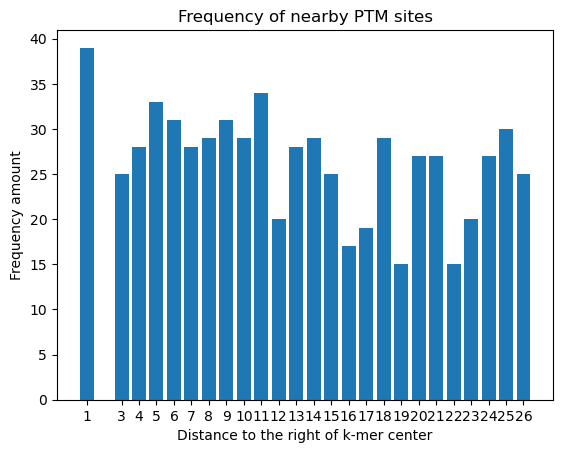

array([[ 1, 39],
       [ 3, 25],
       [ 4, 28],
       [ 5, 33],
       [ 6, 31],
       [ 7, 28],
       [ 8, 29],
       [ 9, 31],
       [10, 29],
       [11, 34],
       [12, 20],
       [13, 28],
       [14, 29],
       [15, 25],
       [16, 17],
       [17, 19],
       [18, 29],
       [19, 15],
       [20, 27],
       [21, 27],
       [22, 15],
       [23, 20],
       [24, 27],
       [25, 30],
       [26, 25]])

In [75]:
def frequency(k, kmers, model):
    """

    Parameters
    ----------
    k : int
        an odd number that specifies that length of the kmer with the
        phosphorylation site in the middle
    kmer : 2D array
        1D array with kmers

    Returns
    -------
    frequencies : 2D array
        2D array with columns distance away from center kmer PTM and 
        frequency of nearby PTMS

    """
    around_ind = k//2
    x=0
    frequencies = {}
    for i in range(kmers.shape[0]):
        if "@" in kmers[i]:
            x+=1
        temp = kmers[i][around_ind+1:]
        for j in range(len(temp)):
            if "@" == temp[j]:
                if j+1 in frequencies.keys():
                    frequencies[j+1] += 1
                else:
                    frequencies[j+1] = 1
    
    frequencies = list(frequencies.items())
    frequencies = np.array(frequencies)
    print (frequencies)
    frequencies = frequencies[frequencies[:,0].argsort()]

    plt.figure(0)
    plt.bar(frequencies[:,0], frequencies[:,1])
    plt.xticks(frequencies[:,0])
    plt.title("Frequency of nearby PTM sites")
    plt.ylabel("Frequency amount")
    plt.xlabel("Distance to the right of k-mer center")
    plt.savefig(model+"_frequencies.pdf", transparent=True)
    plt.show()

    return frequencies


full_trainl, full_testl=labeling(dataset, protein_dict, 24176)
full_datasetl=np.concatenate((full_trainl, full_testl))
frequency (53, full_datasetl[:,0], model="NGlycoSite")